## Get Data

In [1]:
import requests
import pandas as pd

In [2]:
%%time
endpoint = 'https://api.pushshift.io/reddit/search/submission'
params = dict(
    subreddit='jokes',
#     filter='title,body,score',
    sort='desc',
    sort_type='score',
    limit=1_000,
)

response = requests.get(endpoint, params)
content = response.json()
jokes = pd.DataFrame(content['data'])[['title', 'selftext', 'score']]

CPU times: user 71.7 ms, sys: 10.6 ms, total: 82.3 ms
Wall time: 1.38 s


In [3]:
jokes.dropna(inplace=True)
len(jokes)

999

In [4]:
jokes[:10]

,title,selftext,score
0,Calm down about the Net Neutrality thing...,Paying additional money to access certain site...,122825
1,V,V\n\n*Edit: seems like the ctrl key on my keyb...,95020
2,The only two white actors in Black Panther are...,They're the Tolkien white guys.\n\nEdit: Appar...,87338
3,Ajit Pai.,That's it. That's the whole fucking joke.\n\nE...,85664
4,The 2016 US Presidential Election,That's it. That's the entire fucking joke. \n\...,81258
5,Did you hear about the Doctor on the United Fl...,[removed],78292
6,If I had a $ for every post I've seen today ab...,I'd have enough money to view a post next year...,77418
7,Everyone in Hawaii is mad about the malfunctio...,Hawaii **IS** the early warning system.,74636
8,I hate when people ask how I see myself in 3 y...,I don’t have 2020 vision\n\nThis is the only d...,70921
9,This is the dirty joke my 85yo grandad told to...,A male whale and a female whale were swimming ...,67054


## Cleanup

In [5]:
from collections import Counter
import numpy as np

Join title & body

In [6]:
jokes['text'] = jokes.title + ' … ' + jokes.selftext  # it's a single character, the elipsis: to make it easier to learn

Cut off uncommon characters

In [7]:
# turn newlines into blanks, keep only one type of quotes, colons, brackets, dash
jokes.text = jokes.text.str.lower()
jokes.text = jokes.text.apply(lambda t: t\
                              .replace('\n', ' ')\
                              .replace("’", "'").replace('“', "'").replace('”', "'").replace('"', "'")\
                              .replace(';', ':')\
                              .replace('[', '(').replace(']', ')').replace('{', '(').replace('}', ')')
                              .replace('_', '-')
                             )

In [8]:
corpus = ''.join(jokes.text)
f'{len(corpus):,} characters in total'

'382,362 characters in total'

In [9]:
char_freq = pd.Series(Counter(corpus))
char_freq['e'] / len(corpus)  # most frequent letter in the english language

0.09052677828863746

In [10]:
min_freq = len(corpus) * 0.0001  # at least 0.01%
allowed_chars = ''.join(char_freq[char_freq > min_freq].sort_index().index)

print(f'Allowed characters ({len(allowed_chars)}):')
for i, c in enumerate(allowed_chars):
    print(c, end=' ' if i % 10 else '\n')

Allowed characters (50):
 
! $ ' ( ) * , - . /
0 1 2 3 4 5 6 7 8 9
: ? a b c d e f g h
i j k l m n o p q r
s t u v w x y z … 

In [11]:
' ' in allowed_chars

True

In [12]:
jokes.text = jokes.text.apply(lambda t: ''.join(filter(lambda c: c in allowed_chars, t)))

Cut-off outlier lengths

In [13]:
lengths = jokes.text.str.len()
lengths.describe([.01, .2, .25, .5, .75, .98, .99])

count     999.000000
mean      382.609610
std       637.148444
min        11.000000
1%         40.980000
20%        87.000000
25%        96.000000
50%       148.000000
75%       422.500000
98%      1952.480000
99%      2391.560000
max      9149.000000
Name: text, dtype: float64

In [14]:
min_len = np.quantile(lengths, .05)  # cut the  5% shortest ones
max_len = np.quantile(lengths, .75)  # and the 25% longest ones
valid_size_mask = (min_len < lengths) & (lengths < max_len)

In [15]:
curated = jokes[valid_size_mask]
len(curated)

699

## Explore Data

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
%matplotlib inline

In [17]:
rcParams['figure.figsize'] = 8, 6

In [18]:
import warnings
warnings.filterwarnings("ignore")  # unmaintained libs trigger deprecation warnings :(

---

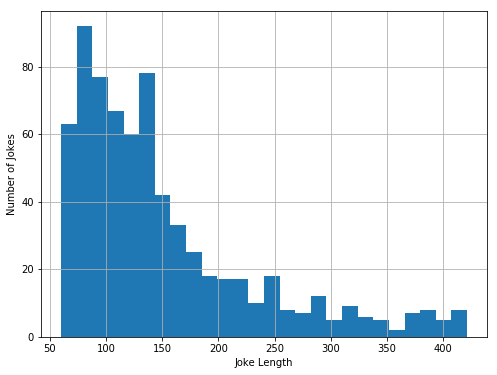

In [19]:
curated.text.str.len().hist(bins=int(np.sqrt(len(curated))))
plt.xlabel('Joke Length')
plt.ylabel('Number of Jokes')
plt.show()

So many of them are short

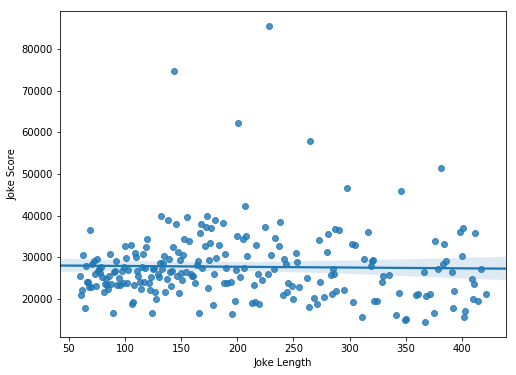

In [20]:
curated['text_len'] = curated.text.str.len()
score_by_len = curated.groupby('text_len').score.mean()
sns.regplot(score_by_len.index.values, score_by_len.values)

plt.xlabel('Joke Length')
plt.ylabel('Joke Score')
plt.show()

## Prepare

Each joke is going to be cut into multiple semi-redundant chunks, eg: "_Why did the chicken cross?_" will generate the following:
     - Why did the
     - did the chi
     - the chicken
     - chicken cro
     - cken cross?
     
Meaning `seq_len = 11` and `seq_step = 4`
     
The model will be trained to predict the next character, given a chunk, eg:
 - "_Why did the_" should make the model predict (blank)
 - "_did the chi_" should make the model predict **c**

In [37]:
shortest = curated.text.str.len().min()
shortest

60

In [60]:
%%time
# cut the text in semi-redundant chunks
seq_len = shortest // 3
seq_step = 2

chunk_next_pairs = []  # each joke will have multiple (text chunk, next character) pairs

for joke in curated.text:
    pairs = []  # current joke's pairs
    for i in range(0, len(joke) - seq_len, seq_step):
        pairs.append((
            joke[i : i + seq_len], 
            joke[i + seq_len]
        ))
    if i < len(joke) - seq_len - 1:  # for the last chunk, that is too short to make a full chunk of its own
        pairs.append((
            joke[-seq_len - 1 : -1], 
            joke[-1]
        ))
    chunk_next_pairs.append(pairs)

CPU times: user 42 ms, sys: 1.61 ms, total: 43.6 ms
Wall time: 42.4 ms


In [61]:
f'{sum(map(len, chunk_next_pairs)):,} total text chunks/next char pairs'

'46,077 total text chunks/next char pairs'

---

Character-wise one hot encoding 

In [62]:
char2idx = {c: i for i, c in enumerate(allowed_chars)}
idx2char = {i: c for i, c in enumerate(allowed_chars)}

In [63]:
n_chars = len(allowed_chars)

In [64]:
%%time
# one-hot encode
jokes_data = []  # each will joke will have an input x and an output y (both same length, and holding the char ohe)

for curr_joke_pairs in chunk_next_pairs:
    x = np.zeros((len(curr_joke_pairs), seq_len, n_chars), dtype=bool)
    y = np.zeros((len(curr_joke_pairs), n_chars), dtype=bool)

    for i, (text_chunk, next_char) in enumerate(curr_joke_pairs):
        for t, curr_char in enumerate(text_chunk):
            x[i, t, char2idx[curr_char]] = 1
        y[i, char2idx[next_char]] = 1
        
    jokes_data.append((x, y))

CPU times: user 280 ms, sys: 9.1 ms, total: 289 ms
Wall time: 285 ms


## Build Model

In [65]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import RMSprop

In [69]:
batch_size = 1  # TODO try larger (need the number of chunks to be divisible by it though, because of being stateful)

In [70]:
# build model
model = Sequential([
    LSTM(128, batch_input_shape=(batch_size, seq_len, n_chars), stateful=True),
    Dense(n_chars, activation='softmax')
])
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(lr=0.01))

## Train

In [137]:
import sys
import random

from keras.callbacks import LambdaCallback

In [131]:
def sample_probas(preds, temperature=1.0):
    """ Sample an index from a probability array """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [147]:
def generate_joke(model, corpus):  # `epoch` and `logs` are keras callback arguments
    """ Generate jokes with different diversities """
    start_index = random.randint(0, len(corpus) - seq_len - 1)
    seed: str = corpus[start_index : start_index + seq_len]
    print(f'Generating with seed: "{seed}"')
    
    for diversity in [0.25, 0.5, 1.0, 1.25]:
        print(f'\n\nDiversity {diversity}')
        length = random.randint(100, 300)
        current_input = seed
        
        for _ in range(length):
            # one hot encoding of current input
            x = np.zeros((1, seq_len, n_chars), dtype=bool)
            for t, char in enumerate(current_input):
                x[0, t, char2idx[char]] = 1

            preds = model.predict(x, verbose=0)[0]
            next_char_index = sample_probas(preds, diversity)
            next_char = idx2char[next_char_index]

            current_input = current_input[1:] + next_char  # rotate and append

            print(next_char, end='')
            sys.stdout.flush()

In [154]:
n_epochs = 10
n_jokes = 5

In [158]:
%%time
for epoch in range(1, n_epochs+1):
    print(f'Epoch {epoch} / {n_epochs}')
    shuffled = random.sample(jokes_data, n_jokes)  # not-in-place shuffle of joke chunks kept together
    
    for i, (x, y) in enumerate(shuffled):
        print('',end='\r')
        sys.stdout.write(f'\rJoke {i+1} / {n_jokes}')
        model.reset_states()  # clear up context before starting a new joke

        history = model.fit(
            x, y,
            batch_size=batch_size,
            epochs=1, verbose=False, shuffle=False
        )

    print('\n')
    generate_joke(model, corpus)
    print('\n')

Epoch 1 / 10
Joke 5 / 5

Generating with seed: "'   blushing, the ag"


Diversity 0.25
en llle in thing in  orll worlle thall an worll worll wing n an llen the a lall an thing worllle worll woren lle in llee lere an thin thin st wor lan lle an wo and wan ll an than lle and wo wo wore the an lle worlle wan than llllle in lal

Diversity 0.5
et worll thing n won ant is t. wan l w all an towing hoot inn wan  in ant itathhing o whan s wond wing inll all wo woring ll iten sal llowen man ing lit wo wan to wan lle wor to lenten forll iing se llen thill wan s

Diversity 1.0
enll are bomat neitn he. a ting nme toand ing owh int ition led intlen iont went hand obing . thelllill i latilst ng mrt woin th. th bare  thing ll ber. … n wad and whe lt so a thennt town p i fooon llere a l llaherllilled. that whal thcill tht ico

Diversity 1.25
td fes thanl nry all ilat nbie lele betl in ligon wor nr lent beth. wer ollllter amah leesend ae townre plding i oange. … foort and weng ' to inge. … matssp msomen

KeyboardInterrupt: 